In [ ]:
# @title Preamble


# Define path to your NetCDF file in Google Drive
nc_path = "./output/merged/time_series_uv.nc"

# Import core libraries
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch

# ERA5 dataset
data_path = "./era5/"
files = [f"{data_path}2022_1.nc", f"{data_path}2022_2.nc", f"{data_path}2023.nc"]

ds = xr.open_dataset(nc_path)
ds_era5 = xr.open_mfdataset(files, combine="by_coords")


In [ ]:
# @title Inspect dataset if needed

# Load dataset
# ds = xr.open_dataset(nc_path)

# Quick dataset summary
# print(ds)

# # Inspect coordinates
# print("\nCoordinates:")
# print("time length:", ds.dims["time"])
# print("x length:", ds.dims["x"])
# print("y length:", ds.dims["y"])

# # Time coverage
# print("\nTime range:")
# print("Start:", str(ds.time.min().values))
# print("End:  ", str(ds.time.max().values))

# # Variables
# print("\nVariables:")
# for v in ds.data_vars:
#     print(v, ds[v].dims, ds[v].shape)

# Quick preview plot of u at first timestep
# ds.u.isel(time=0).plot()
# plt.title("u at first timestep")
# plt.show()


<xarray.Dataset> Size: 239MB
Dimensions:  (time: 10889, y: 37, x: 37)
Coordinates:
  * time     (time) datetime64[ns] 87kB 2022-01-01 ... 2023-05-31T22:00:00
  * y        (y) float64 296B 0.0 0.025 0.05 0.075 0.1 ... 0.825 0.85 0.875 0.9
  * x        (x) float64 296B 0.0 0.025 0.05 0.075 0.1 ... 0.825 0.85 0.875 0.9
Data variables:
    u        (time, y, x) float64 119MB ...
    v        (time, y, x) float64 119MB ...
Attributes:
    title:        Merged hourly u,v timeseries
    institution:  Your Lab
    history:      Merged on 2025-08-21T13:54:13.514919Z


In [6]:
# @title Helper Functions


def plot_with_gaps(time, values, label, color, ax, max_gap="3h"):
    """
    Plot a time series but break lines when gaps are larger than max_gap.
    """
    dt = np.diff(time.values) / np.timedelta64(1, "h")  # in hours
    gap_idx = np.where(dt > pd.Timedelta(max_gap).total_seconds() / 3600)[0]
    split_idx = np.concatenate(([0], gap_idx + 1, [len(time)]))

    for i in range(len(split_idx) - 1):
        start, end = split_idx[i], split_idx[i + 1]
        ax.plot(
            time.values[start:end],
            values.values[start:end],
            color=color,
            label=label if i == 0 else "",
            alpha=0.8,
        )


def plot_wind_speed(ds, time_range=None):
    """
    Plot spatially averaged wind speed (norm of mean velocity),
    then temporally smoothed with 6h and 12h running means.
    """
    # Compute spatial averages of u and v
    u_avg = ds["u"].mean(dim=["y", "x"])
    v_avg = ds["v"].mean(dim=["y", "x"])

    # Compute speed as the norm of averaged u and v
    speed = np.sqrt(u_avg**2 + v_avg**2)

    # Apply running means
    speed_6h = speed.rolling(time=6, center=True).mean()
    speed_12h = speed.rolling(time=12, center=True).mean()

    # Restrict time if requested
    if time_range is not None:
        speed = speed.sel(time=slice(*time_range))
        speed_6h = speed_6h.sel(time=slice(*time_range))
        speed_12h = speed_12h.sel(time=slice(*time_range))

    # Make figure
    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
    fig.suptitle("Wind Speed: Spatial Average → Temporal Smoothing", fontsize=14)

    plot_with_gaps(speed["time"], speed, "Raw", "blue", axes[0])
    axes[0].set_ylabel("Speed (m/s)")
    axes[0].grid(True)
    axes[0].set_title("Spatial average of speed (no smoothing)")

    plot_with_gaps(speed_6h["time"], speed_6h, "6h Running Mean", "blue", axes[1])
    axes[1].set_ylabel("Speed (m/s)")
    axes[1].grid(True)
    axes[1].set_title("Spatial average of speed (6-hour running mean)")

    plot_with_gaps(speed_12h["time"], speed_12h, "12h Running Mean", "blue", axes[2])
    axes[2].set_ylabel("Speed (m/s)")
    axes[2].grid(True)
    axes[2].set_title("Spatial average of speed (12-hour running mean)")

    plt.show()


def plot_wind_direction(ds, time_range=None):
    """
    Plot spatially averaged wind direction (circular mean),
    then temporally smoothed with 6h and 12h running means.
    """
    # Compute instantaneous direction field
    theta = np.rad2deg(np.arctan2(ds["v"], ds["u"]))  # [-180, 180] degrees

    # Circular spatial average
    sin_avg = np.sin(np.deg2rad(theta)).mean(dim=["y", "x"])
    cos_avg = np.cos(np.deg2rad(theta)).mean(dim=["y", "x"])
    theta_avg = np.rad2deg(np.arctan2(sin_avg, cos_avg))

    # Apply running means
    theta_6h = theta_avg.rolling(time=6, center=True).mean()
    theta_12h = theta_avg.rolling(time=12, center=True).mean()

    # Restrict time if requested
    if time_range is not None:
        theta_avg = theta_avg.sel(time=slice(*time_range))
        theta_6h = theta_6h.sel(time=slice(*time_range))
        theta_12h = theta_12h.sel(time=slice(*time_range))

    # Make figure
    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
    fig.suptitle("Wind Direction: Spatial Circular Mean → Temporal Smoothing", fontsize=14)

    plot_with_gaps(theta_avg["time"], theta_avg, "Raw", "red", axes[0])
    axes[0].set_ylabel("Angle (°)")
    axes[0].grid(True)
    axes[0].set_title("Spatial circular mean (no smoothing)")

    plot_with_gaps(theta_6h["time"], theta_6h, "6h Running Mean", "red", axes[1])
    axes[1].set_ylabel("Angle (°)")
    axes[1].grid(True)
    axes[1].set_title("Spatial circular mean (6-hour running mean)")

    plot_with_gaps(theta_12h["time"], theta_12h, "12h Running Mean", "red", axes[2])
    axes[2].set_ylabel("Angle (°)")
    axes[2].grid(True)
    axes[2].set_title("Spatial circular mean (12-hour running mean)")

    plt.show()

def plot_era5_timeseries(vel_mag, theta, time_range=None):
    """
    Plot ERA5 10m wind speed and direction at the nearest gridpoint.

    Parameters
    ----------
    vel_mag : xarray.DataArray
        Wind speed magnitude (m/s), with 'valid_time' coordinate.
    theta : xarray.DataArray
        Wind direction (degrees), with 'valid_time' coordinate.
    time_range : tuple of str, optional
        Start and end time for zooming in (format 'YYYY-MM-DD').
    """

    # Subset by time if a range is provided
    if time_range is not None:
        start, end = time_range
        vel_mag = vel_mag.sel(valid_time=slice(start, end))
        theta = theta.sel(valid_time=slice(start, end))

    # Plot speed
    plt.figure(figsize=(14, 5))
    plt.plot(vel_mag['valid_time'], vel_mag, color="blue", label="Wind Speed")
    plt.ylabel("Speed (m/s)")
    plt.title("ERA5 10m Wind Speed at Nearest Gridpoint")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot direction
    plt.figure(figsize=(14, 5))
    plt.plot(theta['valid_time'], theta, color="red", label="Wind Direction")
    plt.ylabel("Direction (°)")
    plt.title("ERA5 10m Wind Direction at Nearest Gridpoint")
    plt.grid(True)
    plt.legend()
    plt.show()

# Math: Complex rotation + alpha
def compute_alpha(rho_a=1.3, rho_w=1025.0, C_a=1.6e-3, C_w=5.5e-3):
    """
    Returns alpha = sqrt( rho_a * C_a / (rho_w * C_w) )
    Defaults are typical air/water densities (kg/m^3) and drag coeffs.
    """
    return np.sqrt((rho_a * C_a) / (rho_w * C_w))

def rotate_uv(u, v, theta_deg):
    """
    Rotate vector (u, v) by -theta_deg (clockwise) using complex form: e^{-iθ}.
    Returns (u_rot, v_rot) with same type/shape as inputs (xarray-aware).
    """
    theta = np.deg2rad(theta_deg)
    # rotation matrix for clockwise angle θ:
    # [ cosθ  sinθ]
    # [-sinθ  cosθ]
    u_rot =  u * np.cos(theta) + v * np.sin(theta)
    v_rot = -u * np.sin(theta) + v * np.cos(theta)
    return u_rot, v_rot

# Compute ocean current estimate from ice & ERA5
def estimate_ocean_from_ice_and_wind(
    ds_ice,           # Dataset with u,v on dims (time, y, x)
    ds_era5,          # Dataset with u10,v10 on dim time
    theta_deg=25.0,   # turning angle (°) — adjust as needed
    alpha=None,       # if None, compute from defaults; or pass a scalar
    join="inner"      # how to align time: "inner" keeps overlapping timestamps only
):
    if alpha is None:
        alpha = compute_alpha()  # ~0.019–0.02 with defaults

    # Ensure time coordinate names are 'time'
    # (rename here if your ERA5 has 'valid_time')
    if "time" not in ds_era5.dims and "valid_time" in ds_era5.dims:
        ds_era5 = ds_era5.rename({"valid_time": "time"})

    # Select components
    u_i = ds_ice["u"]
    v_i = ds_ice["v"]
    u_a = ds_era5["u10"]
    v_a = ds_era5["v10"]

    # Align by time only (keep common times; no interpolation)
    (u_i_al, v_i_al, u_a_al, v_a_al) = xr.align(u_i, v_i, u_a, v_a, join=join)

    # Broadcast ERA5 (time) to ice grid (time,y,x)
    u_a_b, v_a_b = xr.broadcast(u_a_al, u_i_al), xr.broadcast(v_a_al, v_i_al)
    u_a_b = u_a_b[0]  # broadcast returns tuples; pick the DataArray
    v_a_b = v_a_b[0]

    # Rotate wind by -theta (clockwise) => e^{-iθ}
    u_a_rot, v_a_rot = rotate_uv(u_a_b, v_a_b, theta_deg)

    # Ocean estimate: U_w ≈ U_i - α * (rotated wind)
    u_ocean = u_i_al - alpha * u_a_rot
    v_ocean = v_i_al - alpha * v_a_rot

    # Package into a dataset
    ds_ocean = xr.Dataset(
        {
            "u_ocean": u_ocean,
            "v_ocean": v_ocean,
        },
        coords=u_ocean.coords
    )
    ds_ocean.attrs.update({
        "note": "Ocean current estimate from free-drift balance: U_w ≈ U_i - α e^{-iθ} U_a",
        "theta_deg": theta_deg,
        "alpha": float(alpha),
        "align_join": join,
    })
    return ds_ocean


# Spatial averages + speed time series (with gaps shown)
def nan_gap_segments(time_index, y_vals, max_gap_hours=3):
    """
    Yield segments (t_seg, y_seg) where consecutive time steps are <= max_gap_hours.
    Break segments across NaNs and across large time gaps.
    """
    t = np.asarray(time_index.values)
    y = np.asarray(y_vals)

    # mask for valid numeric
    valid = np.isfinite(y)

    seg_t, seg_y = [], []
    for i in range(len(t)):
        if not valid[i]:
            # flush current segment
            if seg_t:
                yield np.array(seg_t), np.array(seg_y)
                seg_t, seg_y = [], []
            continue

        if seg_t:
            dt_hours = (t[i] - seg_t[-1]) / np.timedelta64(1, 'h')
            if dt_hours > max_gap_hours:
                # break on big gap
                yield np.array(seg_t), np.array(seg_y)
                seg_t, seg_y = [], []

        seg_t.append(t[i])
        seg_y.append(y[i])

    if seg_t:
        yield np.array(seg_t), np.array(seg_y)


# Power Spectrum Functions
def compute_periodogram(u, v, label, dt_hours=1):
    """Compute Welch periodogram of spatial-mean speed."""
    speed = np.hypot(u, v).mean(dim=(list(u.dims)[1:]))  # average over spatial dims
    series = speed.values
    dt = dt_hours * 3600  # seconds

    # Welch’s method
    freqs, psd = welch(series, fs=1/dt, nperseg=len(series)//8)

    # Convert to cycles/day and period in days
    freqs_cpd = freqs * 86400  # [Hz] → [cycles/day]
    periods = 1 / freqs_cpd
    return periods, psd, label

def compute_psd(u, v, label, dt_hours=1):
    """Compute and plot Welch PSD for a speed time series."""
    speed = np.hypot(u, v)

    # take spatial mean across all non-time dims
    spatial_dims = [d for d in speed.dims if d not in ("time", "valid_time")]
    speed = speed.mean(dim=spatial_dims)

    # unify time dimension name
    time_dim = "time" if "time" in speed.dims else "valid_time"

    speed_series = speed.values
    time_series = speed[time_dim].values

    # mask NaNs
    mask = ~np.isnan(speed_series)
    speed_series = speed_series[mask]
    time_series = time_series[mask]

    # sampling frequency (1/hr assumed)
    fs = 1.0 / dt_hours

    # Welch PSD
    f, Pxx = welch(speed_series, fs=fs, nperseg=7*24, detrend="linear")

    # Plot
    plt.semilogy(f*24, Pxx, label=label)





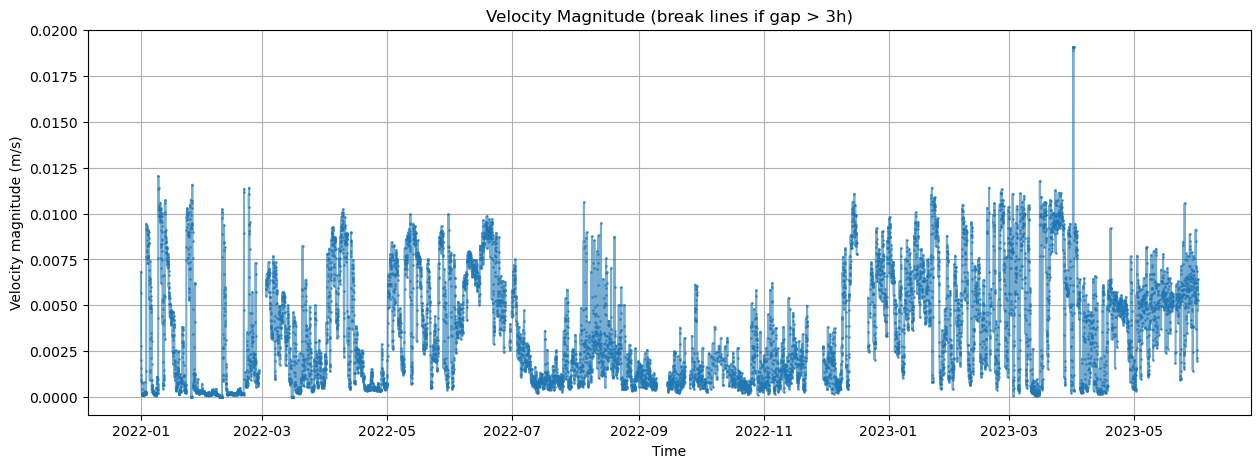

In [7]:
# @title Plot the sea ice data set while explicitly showing gaps via filter

# Compute velocity magnitude
vel_mag = np.sqrt(ds["u"]**2 + ds["v"]**2)

# # Collapse to 1D by averaging across space
vel_mag_mean = vel_mag.mean(dim=("y", "x"))

# Extract time and values
t = vel_mag_mean['time'].values
v = vel_mag_mean.values

# Compute time gaps (in hours)
dt = np.diff(t) / np.timedelta64(1, 'h')

# Insert NaN where gap > 3h
v_break = v.copy()
mask = np.where(dt > 3)[0] + 1
v_break[mask] = np.nan

# Plot with breaks
plt.figure(figsize=(15,5))
plt.plot(t, v_break, marker='.', linestyle='-', alpha=0.6, ms=2)

plt.title("Velocity Magnitude (break lines if gap > 3h)")
plt.ylabel("Velocity magnitude (m/s)")
plt.xlabel("Time")
plt.grid(True)
plt.show()


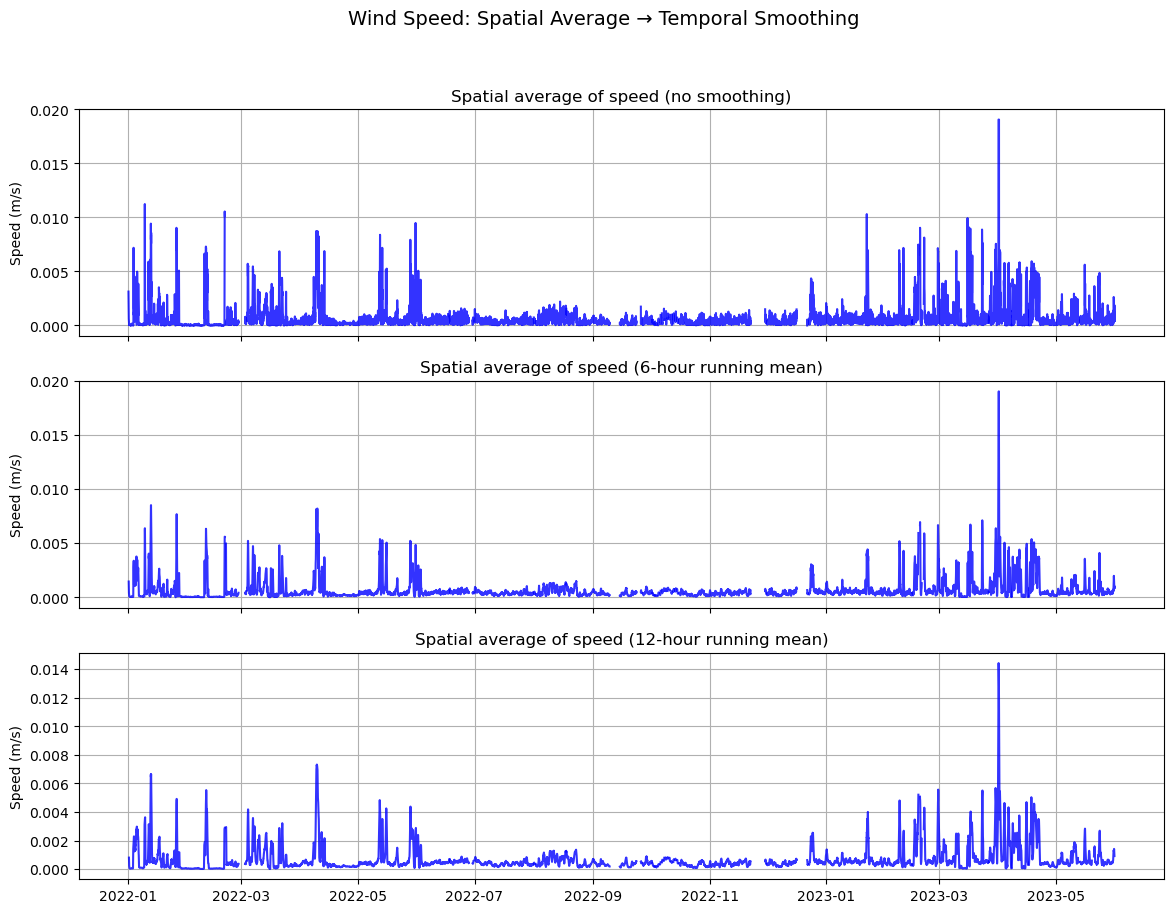

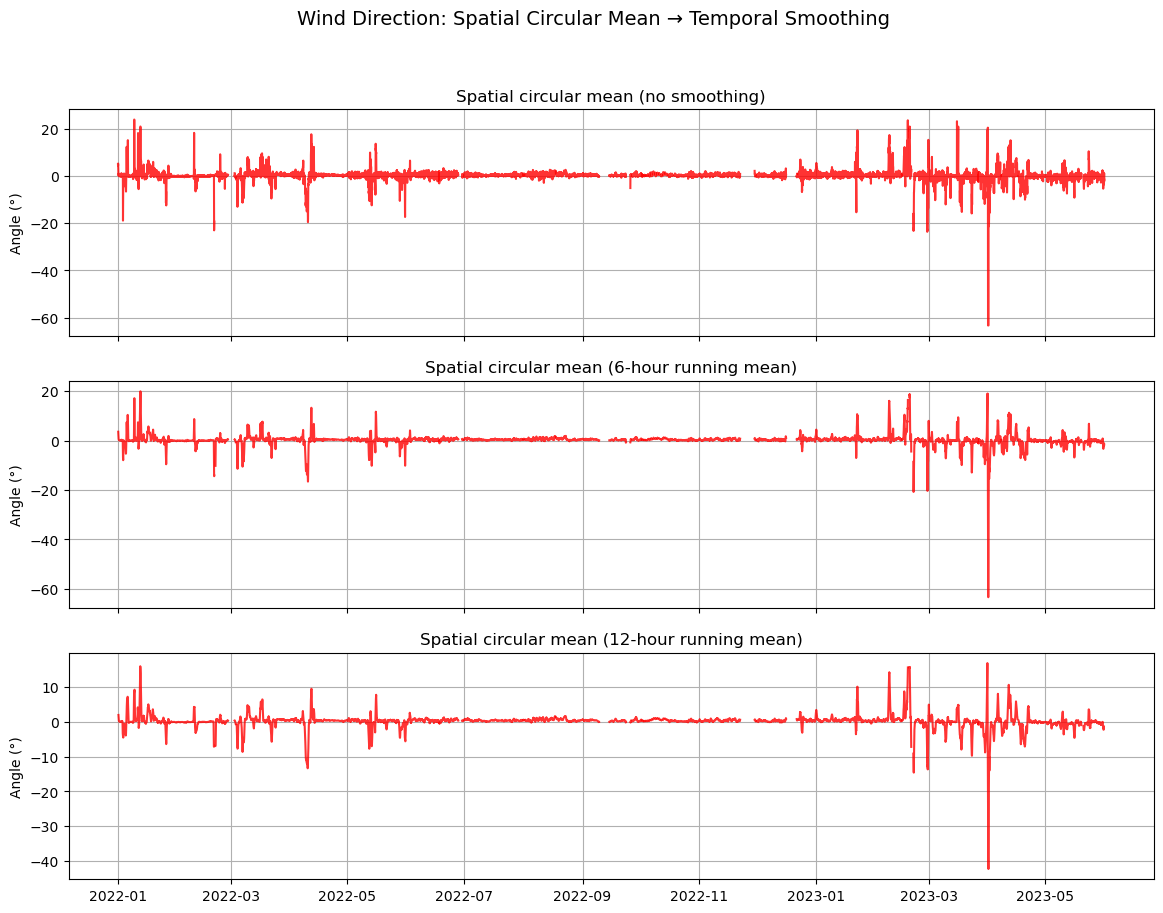

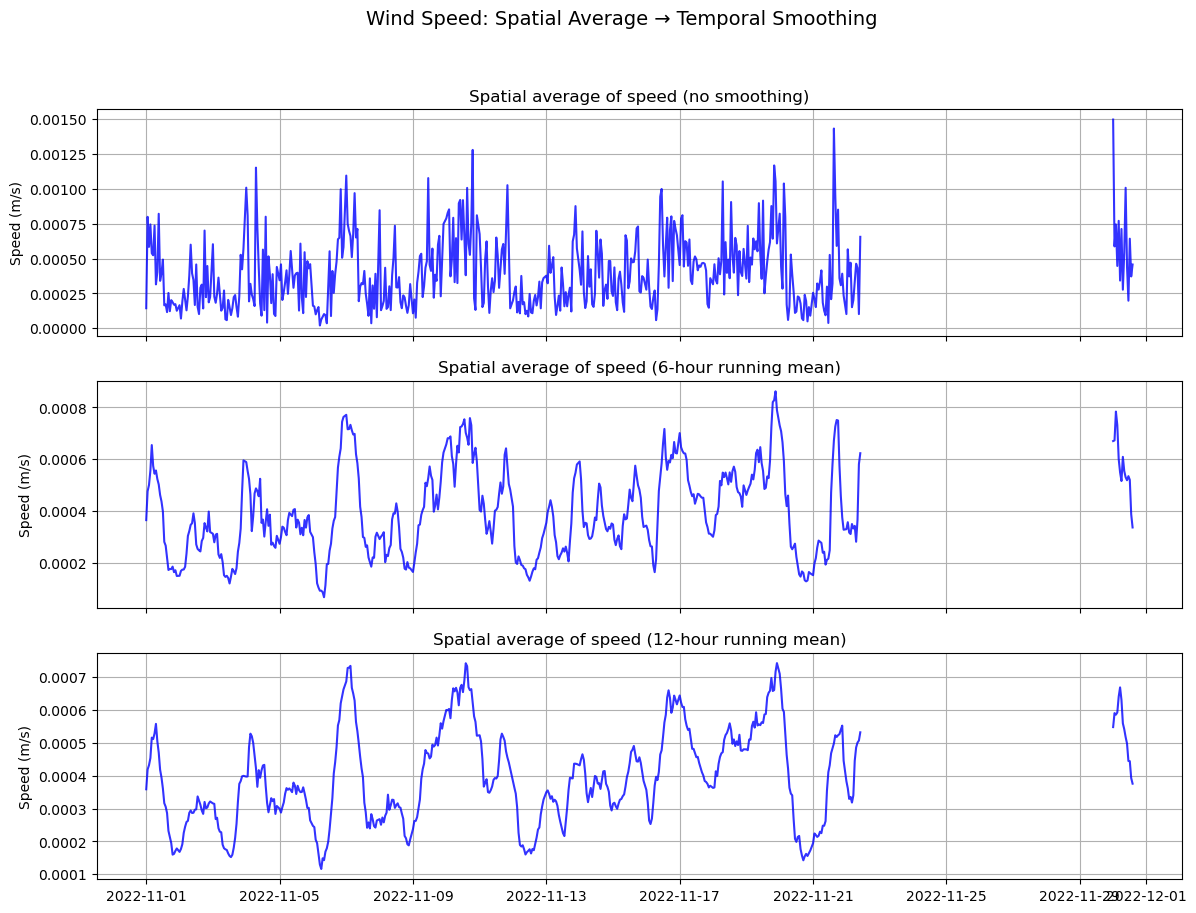

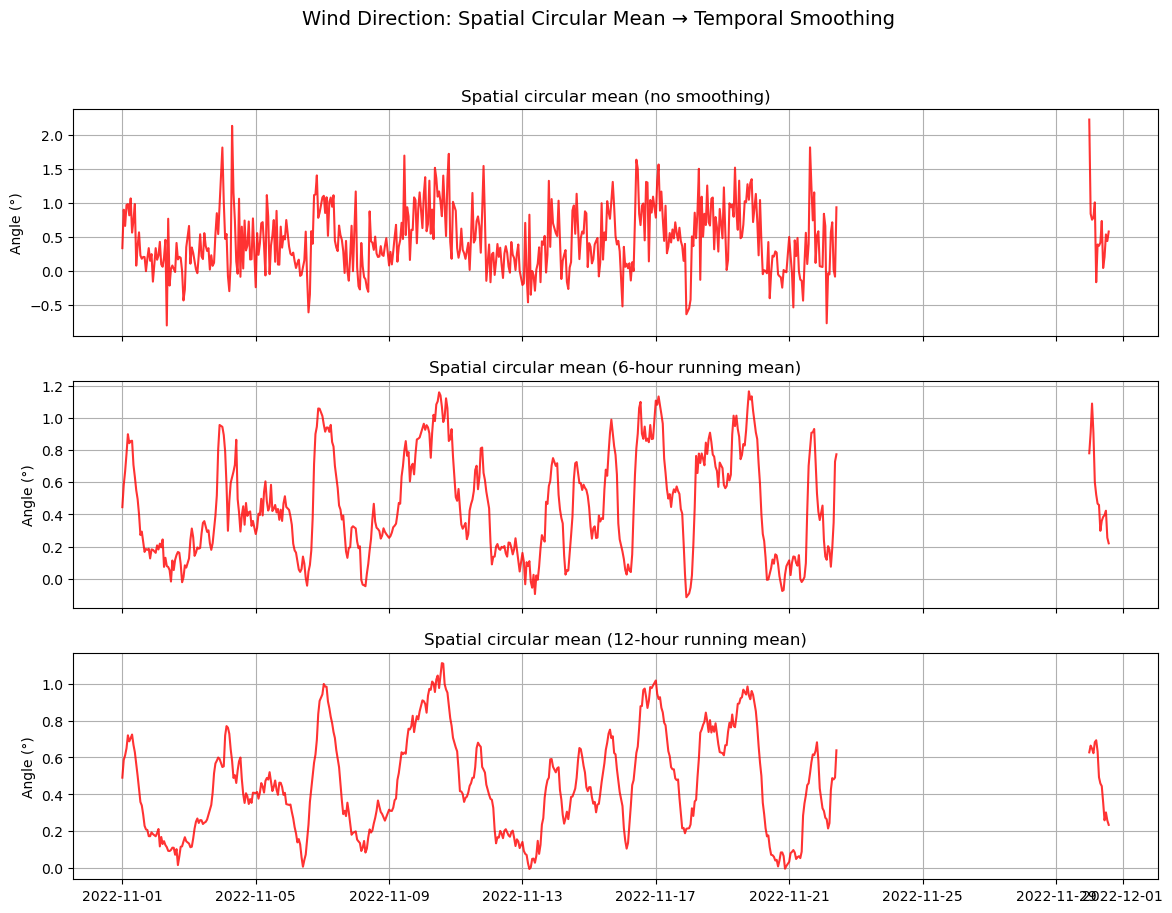

In [8]:
# @title Plot Sea Ice Speed and Direction: sapatially averaged, then a 6h running mean then a 12h running mean

# Plot full record
plot_wind_speed(ds)
plot_wind_direction(ds)

# Zoom to November 2022
plot_wind_speed(ds, time_range=("2022-11-01", "2022-11-30"))
plot_wind_direction(ds, time_range=("2022-11-01", "2022-11-30"))


In [9]:
# @title Era5 treatment

# Target coordinates
target_lat = 71.292222
target_lon = -156.788056

# Find nearest grid point in ERA5
lat_idx = ds_era5['latitude'].sel(latitude=target_lat, method="nearest").values
lon_idx = ds_era5['longitude'].sel(longitude=target_lon, method="nearest").values

print("Nearest ERA5 gridpoint:", float(lat_idx), float(lon_idx))

# Extract timeseries at nearest gridpoint
u10_series = ds_era5['u10'].sel(latitude=lat_idx, longitude=lon_idx)
v10_series = ds_era5['v10'].sel(latitude=lat_idx, longitude=lon_idx)

# Compute velocity magnitude and wind direction
vel_mag_era5 = np.sqrt(u10_series**2 + v10_series**2)
theta_era5 = np.rad2deg(np.arctan2(v10_series, u10_series))  # atan2(v, u) in degrees


Nearest ERA5 gridpoint: 71.25 -156.75


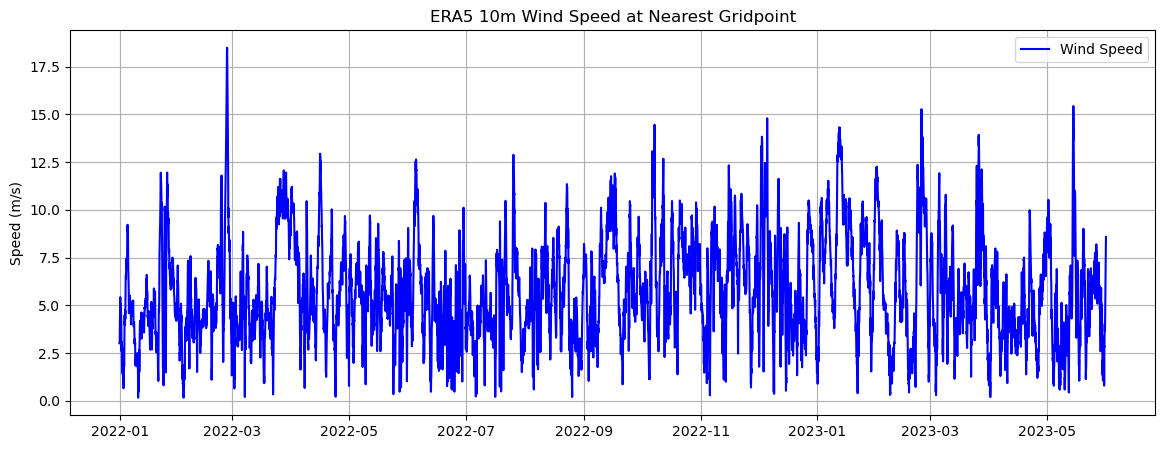

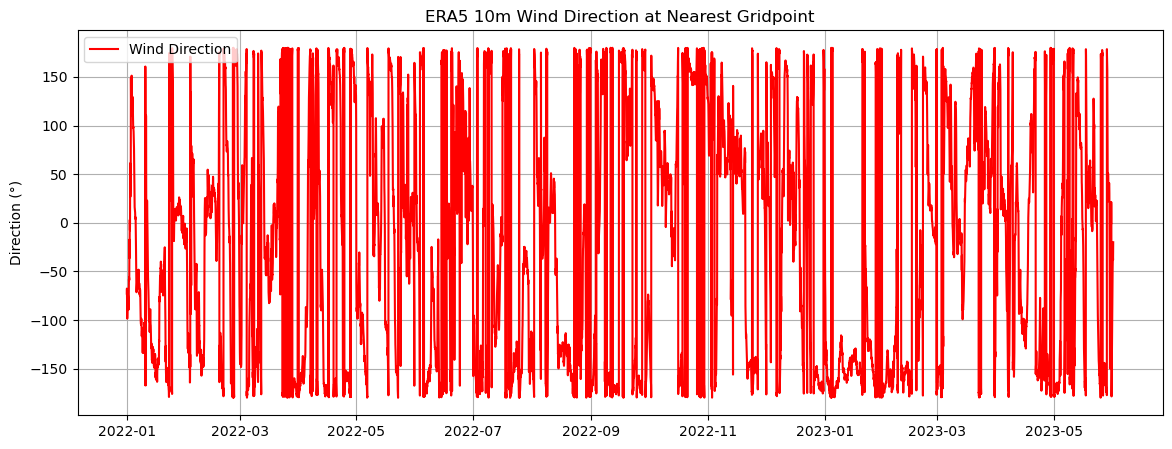

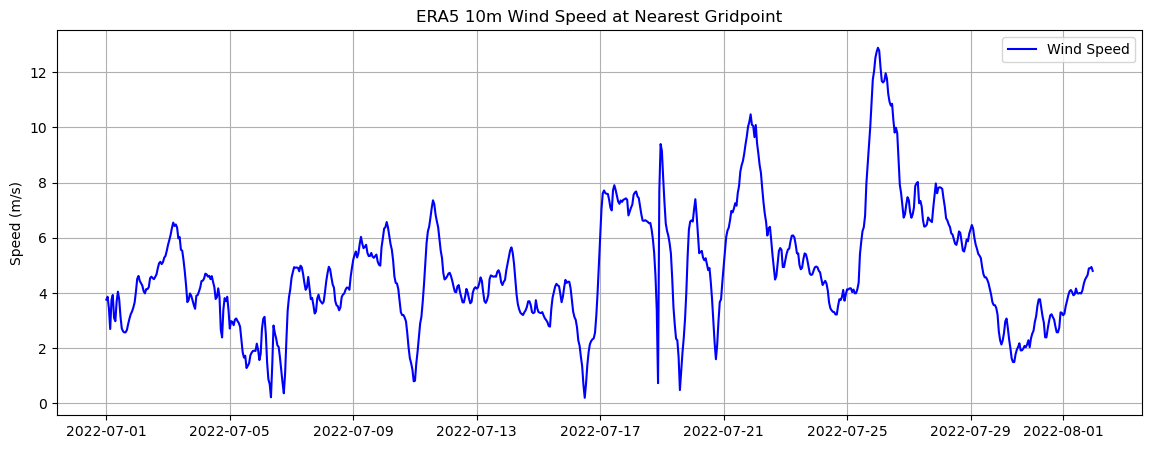

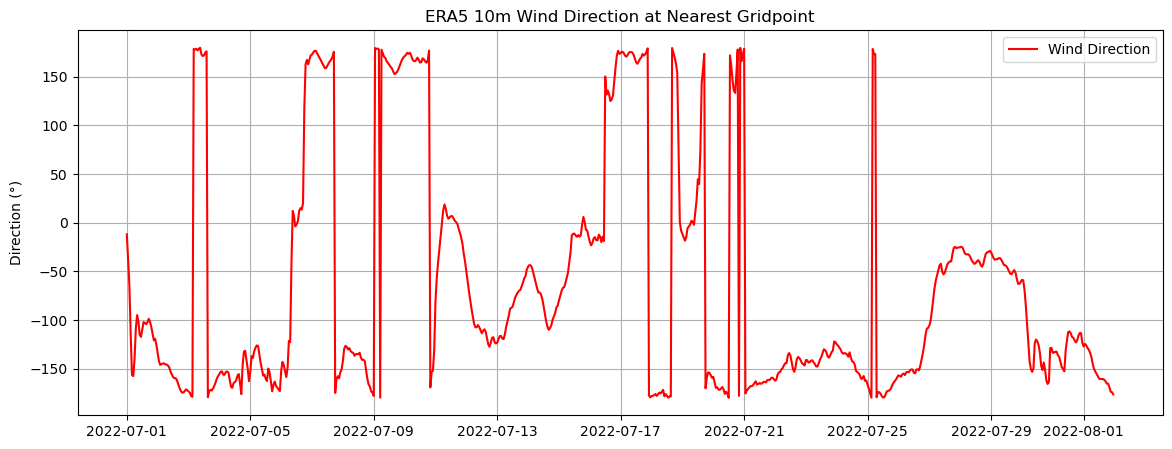

In [10]:
# @title Plot Era5 Speed and Direction

# Full dataset
plot_era5_timeseries(vel_mag_era5, theta_era5)

# Zoom in on July 2022
plot_era5_timeseries(vel_mag_era5, theta_era5, time_range=("2022-07-01", "2022-08-01"))


<xarray.Dataset> Size: 239MB
Dimensions:    (time: 10889, y: 37, x: 37)
Coordinates:
  * time       (time) datetime64[ns] 87kB 2022-01-01 ... 2023-05-31T22:00:00
  * y          (y) float64 296B 0.0 0.025 0.05 0.075 ... 0.825 0.85 0.875 0.9
  * x          (x) float64 296B 0.0 0.025 0.05 0.075 ... 0.825 0.85 0.875 0.9
    number     int64 8B 0
    latitude   float64 8B 71.25
    longitude  float64 8B -156.8
    expver     (time) <U4 174kB dask.array<chunksize=(4128,), meta=np.ndarray>
Data variables:
    u_ocean    (time, y, x) float64 119MB dask.array<chunksize=(4128, 37, 37), meta=np.ndarray>
    v_ocean    (time, y, x) float64 119MB dask.array<chunksize=(4128, 37, 37), meta=np.ndarray>
Attributes:
    note:        Ocean current estimate from free-drift balance: U_w ≈ U_i - ...
    theta_deg:   25.0
    alpha:       0.01920827611725987
    align_join:  inner


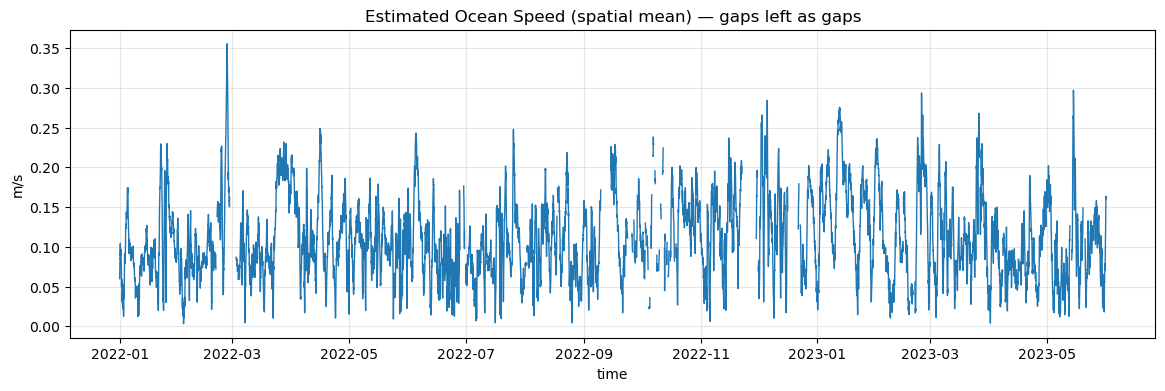

In [11]:
# @title Estimate ocean drift

theta_deg = 25.0   # try 20–30 to see sensitivity
alpha_val = None   # or set e.g., alpha_val = 0.02

# Select nearest ERA5 point (lat/lon)
target_lat, target_lon = 71.25, -156.75
ds_era5_point = ds_era5.sel(latitude=target_lat, longitude=target_lon, method="nearest")

# Now compute ocean currents (only time,y,x, not 5D)
ds_ocean = estimate_ocean_from_ice_and_wind(
    ds,
    ds_era5_point,   # use single-point ERA5
    theta_deg=25.0,
    alpha=None,
    join="inner"
)

print(ds_ocean)

# spatial mean speed
speed_ocean = np.hypot(ds_ocean["u_ocean"], ds_ocean["v_ocean"]).mean(dim=("y","x"))

plt.figure(figsize=(14,4))
for t_seg, y_seg in nan_gap_segments(speed_ocean["time"], speed_ocean.values, max_gap_hours=3):
    plt.plot(t_seg, y_seg, lw=1, color="C0")  # fixed color. Previously the above func caused multiple colors for each segment


plt.title("Estimated Ocean Speed (spatial mean) — gaps left as gaps")
plt.ylabel("m/s")
plt.xlabel("time")
plt.grid(True, alpha=0.3)
plt.show()


<xarray.Dataset> Size: 239MB
Dimensions:    (time: 10889, y: 37, x: 37)
Coordinates:
  * time       (time) datetime64[ns] 87kB 2022-01-01 ... 2023-05-31T22:00:00
  * y          (y) float64 296B 0.0 0.025 0.05 0.075 ... 0.825 0.85 0.875 0.9
  * x          (x) float64 296B 0.0 0.025 0.05 0.075 ... 0.825 0.85 0.875 0.9
    number     int64 8B 0
    latitude   float64 8B 71.25
    longitude  float64 8B -156.8
    expver     (time) <U4 174kB dask.array<chunksize=(4128,), meta=np.ndarray>
Data variables:
    u_ocean    (time, y, x) float64 119MB dask.array<chunksize=(4128, 37, 37), meta=np.ndarray>
    v_ocean    (time, y, x) float64 119MB dask.array<chunksize=(4128, 37, 37), meta=np.ndarray>
Attributes:
    note:        Ocean current estimate from free-drift balance: U_w ≈ U_i - ...
    theta_deg:   25.0
    alpha:       0.01920827611725987
    align_join:  inner


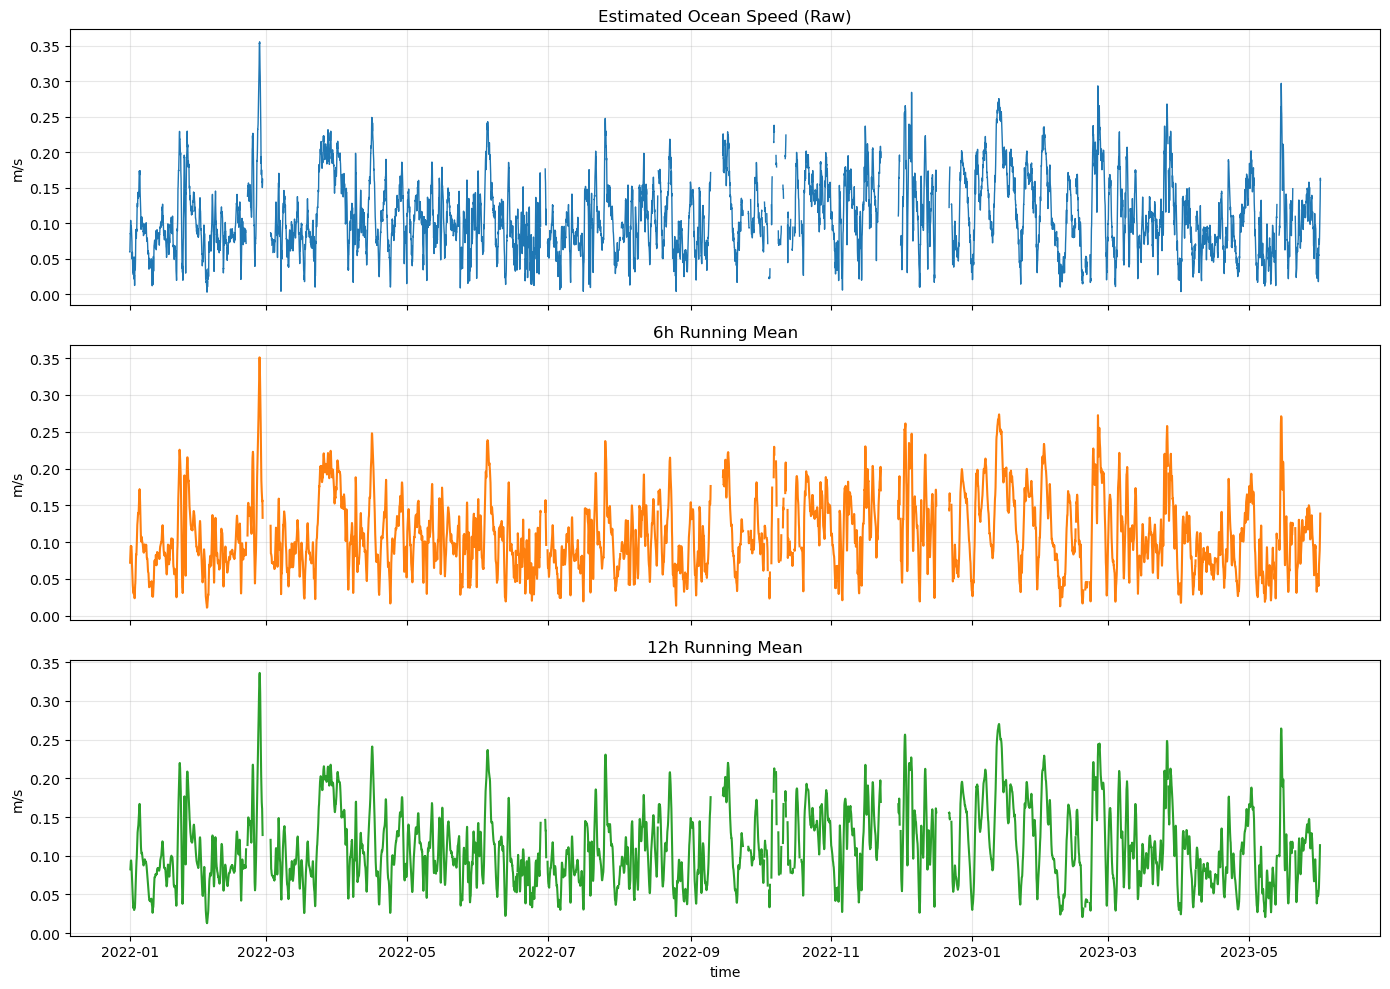

In [12]:
# @title Estimate ocean drift (raw vs smoothed, 3-panel plot)

theta_deg = 25.0   # try 20–30 to see sensitivity
alpha_val = None   # or set e.g., alpha_val = 0.02

# Select nearest ERA5 point (lat/lon)
target_lat, target_lon = 71.25, -156.75
ds_era5_point = ds_era5.sel(latitude=target_lat, longitude=target_lon, method="nearest")

# Compute ocean currents
ds_ocean = estimate_ocean_from_ice_and_wind(
    ds,
    ds_era5_point,
    theta_deg=theta_deg,
    alpha=alpha_val,
    join="inner"
)

print(ds_ocean)

# Spatial mean speed
speed_ocean = np.hypot(ds_ocean["u_ocean"], ds_ocean["v_ocean"]).mean(dim=("y","x"))

# Apply rolling means (assuming hourly data!)
speed_ocean_6h = speed_ocean.rolling(time=6, center=True).mean()
speed_ocean_12h = speed_ocean.rolling(time=12, center=True).mean()

# --- Plot ---
fig, axes = plt.subplots(3, 1, figsize=(14,10), sharex=True)

# Raw
for t_seg, y_seg in nan_gap_segments(speed_ocean["time"], speed_ocean.values, max_gap_hours=3):
    axes[0].plot(t_seg, y_seg, lw=1, color="C0")
axes[0].set_title("Estimated Ocean Speed (Raw)")
axes[0].set_ylabel("m/s")
axes[0].grid(True, alpha=0.3)

# 6h smoothed
for t_seg, y_seg in nan_gap_segments(speed_ocean_6h["time"], speed_ocean_6h.values, max_gap_hours=3):
    axes[1].plot(t_seg, y_seg, lw=1.5, color="C1")
axes[1].set_title("6h Running Mean")
axes[1].set_ylabel("m/s")
axes[1].grid(True, alpha=0.3)

# 12h smoothed
for t_seg, y_seg in nan_gap_segments(speed_ocean_12h["time"], speed_ocean_12h.values, max_gap_hours=3):
    axes[2].plot(t_seg, y_seg, lw=1.5, color="C2")
axes[2].set_title("12h Running Mean")
axes[2].set_ylabel("m/s")
axes[2].set_xlabel("time")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


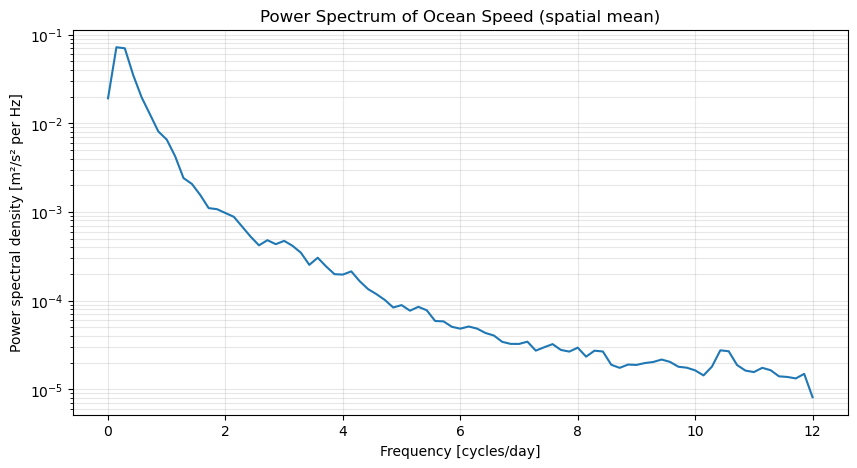

In [13]:
# @title Power Spectrum Test

# convert to numpy, drop NaNs
speed_series = speed_ocean.values
time_series = speed_ocean["time"].values

# remove NaNs so Welch doesn't choke
mask = ~np.isnan(speed_series)
speed_series = speed_series[mask]
time_series = time_series[mask]

# sampling frequency (ERA5 is hourly, right?)
dt_hours = np.median(np.diff(time_series).astype("timedelta64[h]").astype(float))
fs = 1.0 / dt_hours  # samples per hour

# Welch PSD
f, Pxx = welch(speed_series, fs=fs, nperseg=7*24, detrend="linear")
# nperseg=7*24 → ~1 week window

# Plot
plt.figure(figsize=(10,5))
plt.semilogy(f*24, Pxx)  # convert frequency to cycles/day
plt.xlabel("Frequency [cycles/day]")
plt.ylabel("Power spectral density [m²/s² per Hz]")
plt.title("Power Spectrum of Ocean Speed (spatial mean)")
plt.grid(True, which="both", alpha=0.3)
plt.show()


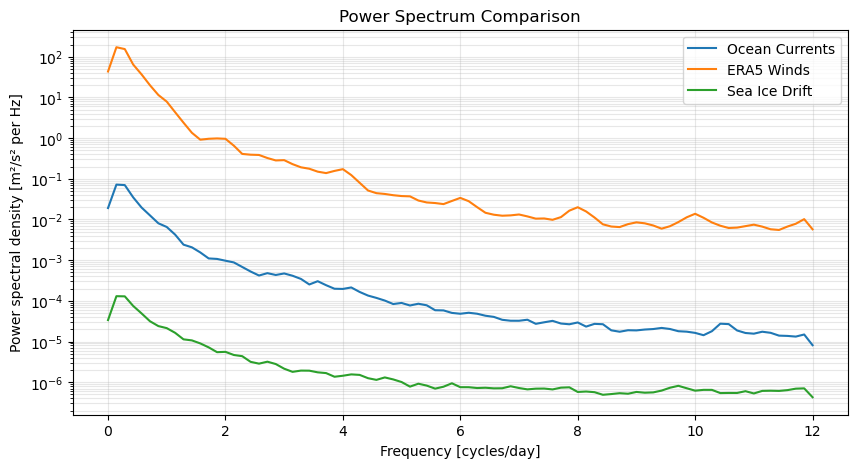

In [14]:
# @title Power Spectrum 1

# Figure
plt.figure(figsize=(10,5))
compute_psd(ds_ocean["u_ocean"], ds_ocean["v_ocean"], "Ocean Currents")
compute_psd(ds_era5["u10"], ds_era5["v10"], "ERA5 Winds")
compute_psd(ds["u"], ds["v"], "Sea Ice Drift")

plt.xlabel("Frequency [cycles/day]")
plt.ylabel("Power spectral density [m²/s² per Hz]")
plt.title("Power Spectrum Comparison")
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.show()


/tmp/ipykernel_5046/3680438747.py:271: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / freqs_cpd
/tmp/ipykernel_5046/3680438747.py:271: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / freqs_cpd
/tmp/ipykernel_5046/3680438747.py:271: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / freqs_cpd


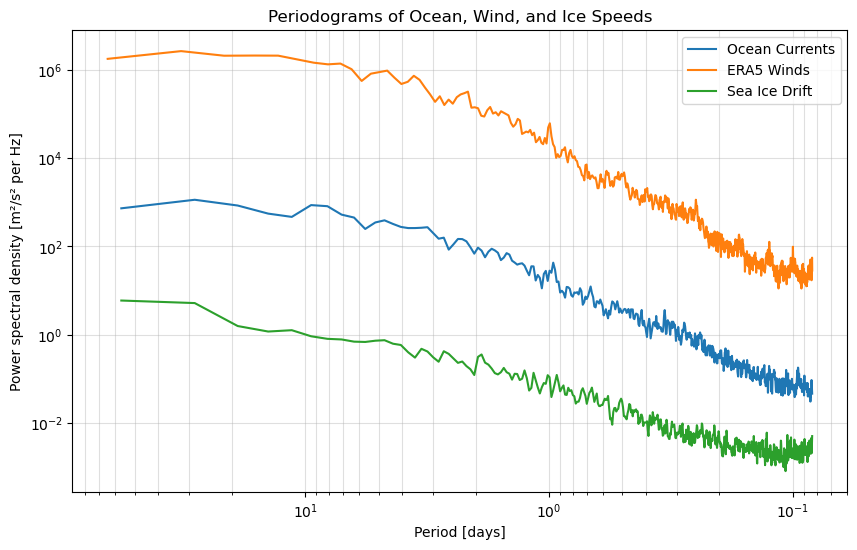

In [15]:
# @title Power Spectrum 2


# Compute
periods_ocean, psd_ocean, _ = compute_periodogram(ds_ocean["u_ocean"], ds_ocean["v_ocean"], "Ocean Currents")
periods_wind, psd_wind, _   = compute_periodogram(ds_era5["u10"], ds_era5["v10"], "ERA5 Winds")
periods_ice, psd_ice, _     = compute_periodogram(ds["u"], ds["v"], "Sea Ice Drift")

# Plot
plt.figure(figsize=(10,6))
plt.loglog(periods_ocean, psd_ocean, label="Ocean Currents")
plt.loglog(periods_wind, psd_wind, label="ERA5 Winds")
plt.loglog(periods_ice, psd_ice, label="Sea Ice Drift")

plt.xlabel("Period [days]")
plt.ylabel("Power spectral density [m²/s² per Hz]")
plt.title("Periodograms of Ocean, Wind, and Ice Speeds")
plt.grid(True, which="both", alpha=0.4)
plt.legend()
plt.gca().invert_xaxis()  # so short periods (hours–days) are on the right
plt.show()


In [ ]:
# In SSH the command I ran finally was

# (base) [ashnoot@fjord ~]$ python merge_uv_timeseries.py   --root /aos/home/ashnoot/radar/netcdf_output   --out  /aos/home/ashnoot/radar/netcdf_output/time_series_uv.nc